# Try out plots

## Lets see how the small scale contribution is related to the large scale on a local level (scatter plot)

In [1]:
import json
import gcsfs
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from dask.distributed import Client, LocalCluster
import dask
import zarr
from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs

from utils import smooth_inputs_dataset, scale_separation, smooth_inputs
from cm26_utils import load_and_combine_cm26

from xhistogram.xarray import histogram


# set up gcs filesystem
# 👇 replace with your key 
with open( '/home/jovyan/KEYS/pangeo-forge-ocean-transport-4967-347e2048c5a1.json') as token_file:
    token = json.load(token_file)
fs = gcsfs.GCSFileSystem(token=token)
%config InlineBackend.figure_format='retina'

In [2]:
# from dask_gateway import Gateway
# gateway = Gateway()

# does this fix the mysterious StreamClosedError (not really) 
# import dask
# dask.config.set(
#     {
#         "distributed.comm.timeouts.tcp": "240s",
#         "distributed.comm.timeouts.connect": "240s",
#     }
# )


# # close existing clusters
# open_clusters = gateway.list_clusters()
# print(list(open_clusters))
# if len(open_clusters)>0:
#     for c in open_clusters:
#         cluster = gateway.connect(c.name)
#         cluster.shutdown()  

# options = gateway.cluster_options()

# options.worker_memory = 50 # 24 works fine for long term mean, but seasonal needs a bit more
# options.worker_cores = 12
# options.

# options.environment = dict(
#     DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0"
# )

# # Create a cluster with those options
# cluster = gateway.new_cluster(options)
# client = cluster.get_client()
# # cluster.adapt(5, 200)
# cluster.scale(40)
# client

from distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=4, threads_per_worker=2)
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:39437' processes=4 threads=8, memory=58.87 GiB>

In [3]:
def load_results(mapper):
    ds_loaded = xr.open_dataset(
        mapper,
        engine='zarr',
        chunks={},
        consolidated=True,
        # inline_array=True
    )
    return ds_loaded

In [4]:
# fs.ls('ocean-transport-group/scale-aware-air-sea/flux-output-processed') #TODO: Delete this?

In [5]:
fs.ls('ocean-transport-group/scale-aware-air-sea/results') #TODO: Delete this?

['ocean-transport-group/scale-aware-air-sea/results/cm26_combined_map.zarr',
 'ocean-transport-group/scale-aware-air-sea/results/cm26_eke.zarr',
 'ocean-transport-group/scale-aware-air-sea/results/cm26_flux_long_term_mean_v2.zarr',
 'ocean-transport-group/scale-aware-air-sea/results/cm26_flux_seasonal_mean_v2.zarr',
 'ocean-transport-group/scale-aware-air-sea/results/cm26_full_flux_histogram.zarr',
 'ocean-transport-group/scale-aware-air-sea/results/cm26_full_flux_histogram_qh.zarr']

In [6]:
mapper = fs.get_mapper('ocean-transport-group/scale-aware-air-sea/flux-output/cm26_split_full_v2.zarr')
ds = load_results(mapper)
ds

<xarray.Dataset>
Dimensions:    (algo: 5, smoothing: 4, time: 7305, yt_ocean: 2700,
                xt_ocean: 3600)
Coordinates:
  * algo       (algo) <U8 'ncar' 'ecmwf' 'coare3p0' 'coare3p6' 'andreas'
  * smoothing  (smoothing) <U13 'smooth_full' 'smooth_tracer' ... 'smooth_all'
  * time       (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    evap       (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    qh         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    ql         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    taux       (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    tauy       (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>

In [7]:
mapper = fs.get_mapper('ocean-transport-group/scale-aware-air-sea/results/cm26_flux_long_term_mean_v2.zarr')
ds_mean = load_results(mapper)
ds_mean

<xarray.Dataset>
Dimensions:    (algo: 5, smoothing: 4, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * algo       (algo) <U8 'ncar' 'ecmwf' 'coare3p0' 'coare3p6' 'andreas'
  * smoothing  (smoothing) <U13 'smooth_full' 'smooth_tracer' ... 'smooth_all'
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    evap       (smoothing, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>
    qh         (smoothing, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>
    ql         (smoothing, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>
    taux       (smoothing, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>
    tauy       (smoothing, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>

In [8]:
mask_mapper = fs.get_mapper('ocean-transport-group/scale-aware-air-sea/results/cm26_combined_map.zarr')
mask_combined = load_results(mask_mapper)['ice_land_mask']

eke_mapper = fs.get_mapper('ocean-transport-group/scale-aware-air-sea/results/cm26_eke.zarr')
ds_eke = load_results(eke_mapper)

In [9]:
#TODO: replace
filter_scale = 50
ds_full, ds_large_scale, ds_small_scale = scale_separation(ds, filter_scale, mask_combined)
ds_full_mean, ds_large_scale_mean, ds_small_scale_mean = scale_separation(ds_mean, filter_scale, mask_combined)

## does the story (velocities explains most of the small scale signsl) hold for daily means? SORTA...

In [21]:
roi = {'xt_ocean':slice(-250, -100), 'yt_ocean':slice(10,50)}
ds_test = ds[['ql']].sel(algo='ecmwf', **roi).isel(time=0).load()

In [22]:
# smooth everythign (for now dont worry about the smooth_all being double filtered)
ds_smoothed = smooth_inputs_dataset(ds_test, ['yt_ocean', 'xt_ocean'], filter_scale=filter_scale)


In [23]:
da_plot_smooth = ds_smoothed['ql'].load()
da_plot = ds_test['ql'].load()

In [27]:
# small_scale.sel(smoothing=['smooth_tracer', 'smooth_vel'])

<Figure size 640x480 with 0 Axes>

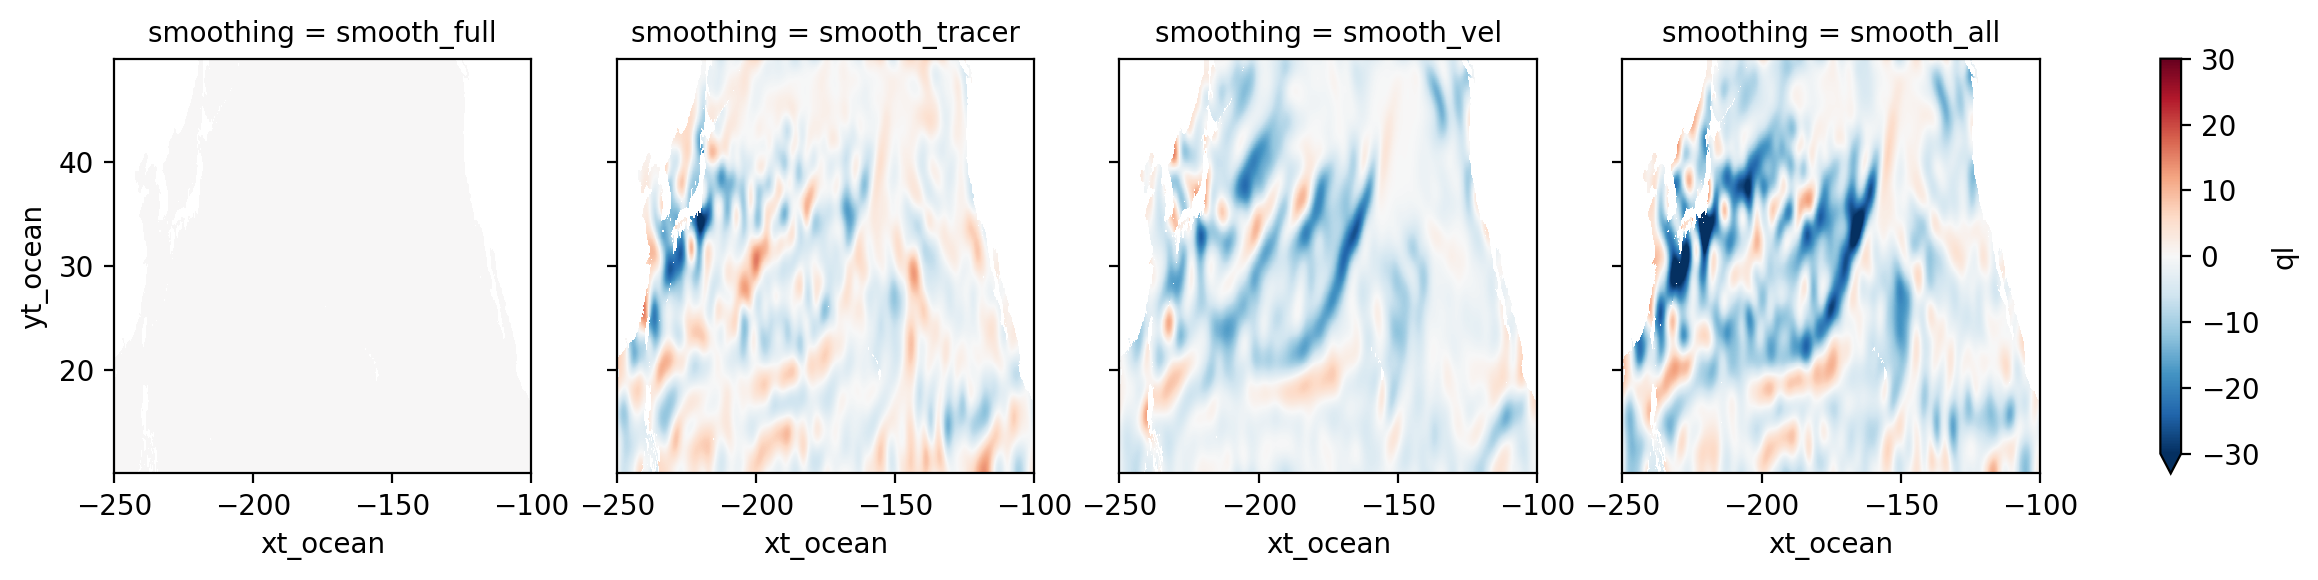

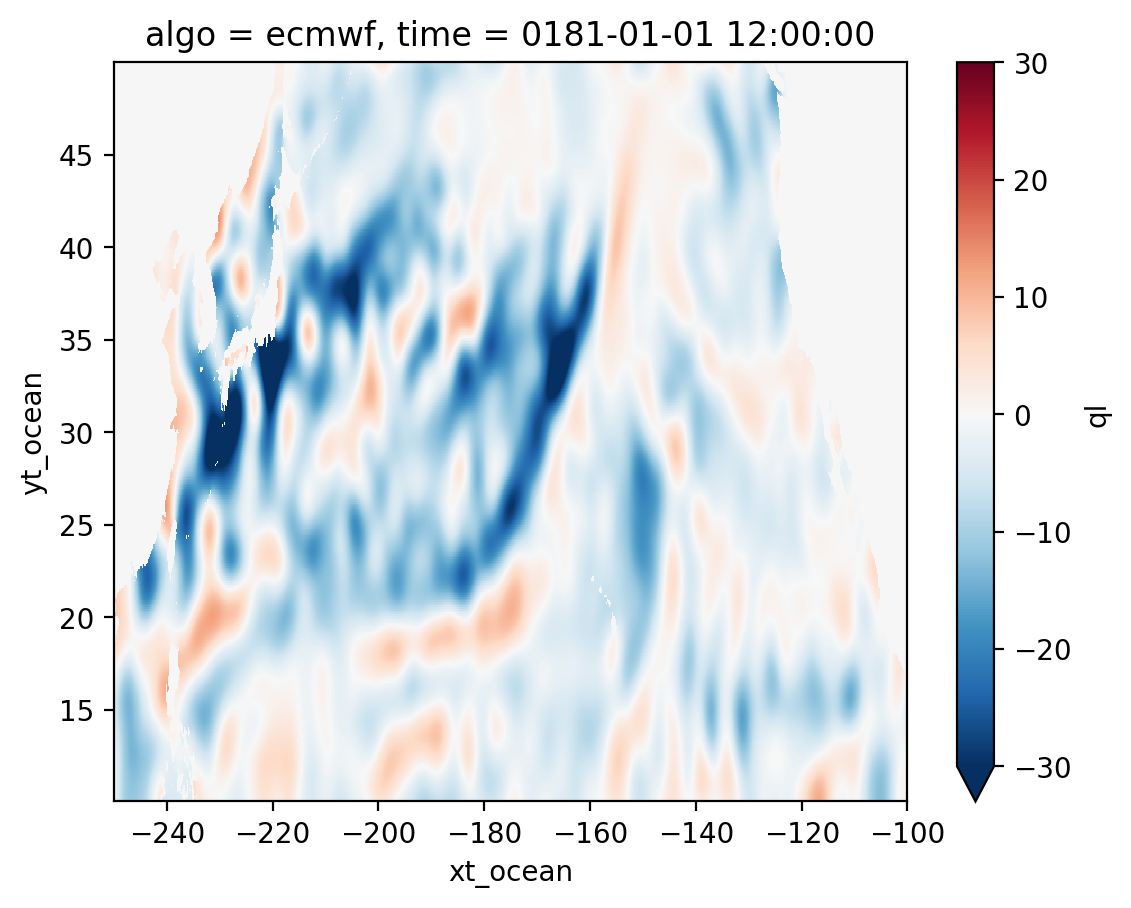

In [28]:
# plt.figure()
# da_plot.plot(col='smoothing',vmin=-300, vmax=-50)

# plt.figure()
# da_plot_smooth.plot(col='smoothing',vmin=-300, vmax=-50)

small_scale = (da_plot_smooth.sel(smoothing='smooth_full') - da_plot_smooth)
plt.figure()
small_scale.plot(col='smoothing',center=0, vmax=30)

plt.figure()
small_scale.sel(smoothing=['smooth_tracer', 'smooth_vel']).sum('smoothing').plot(center=0, vmax=30)

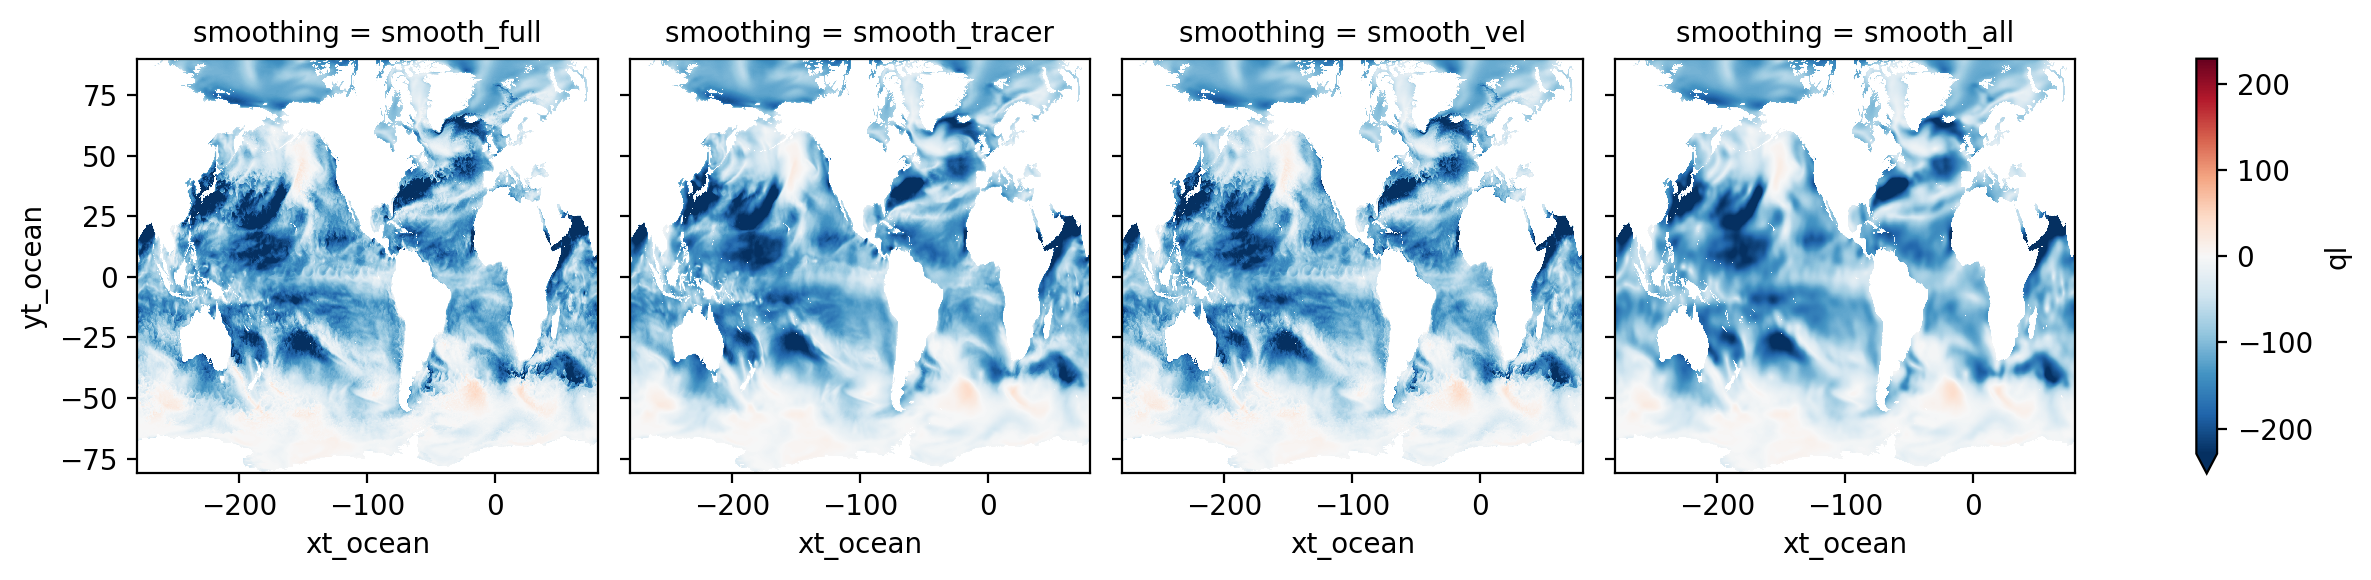

In [22]:
ds['ql'].sel(algo='ecmwf').isel(time=0).plot(col='smoothing',robust=True)

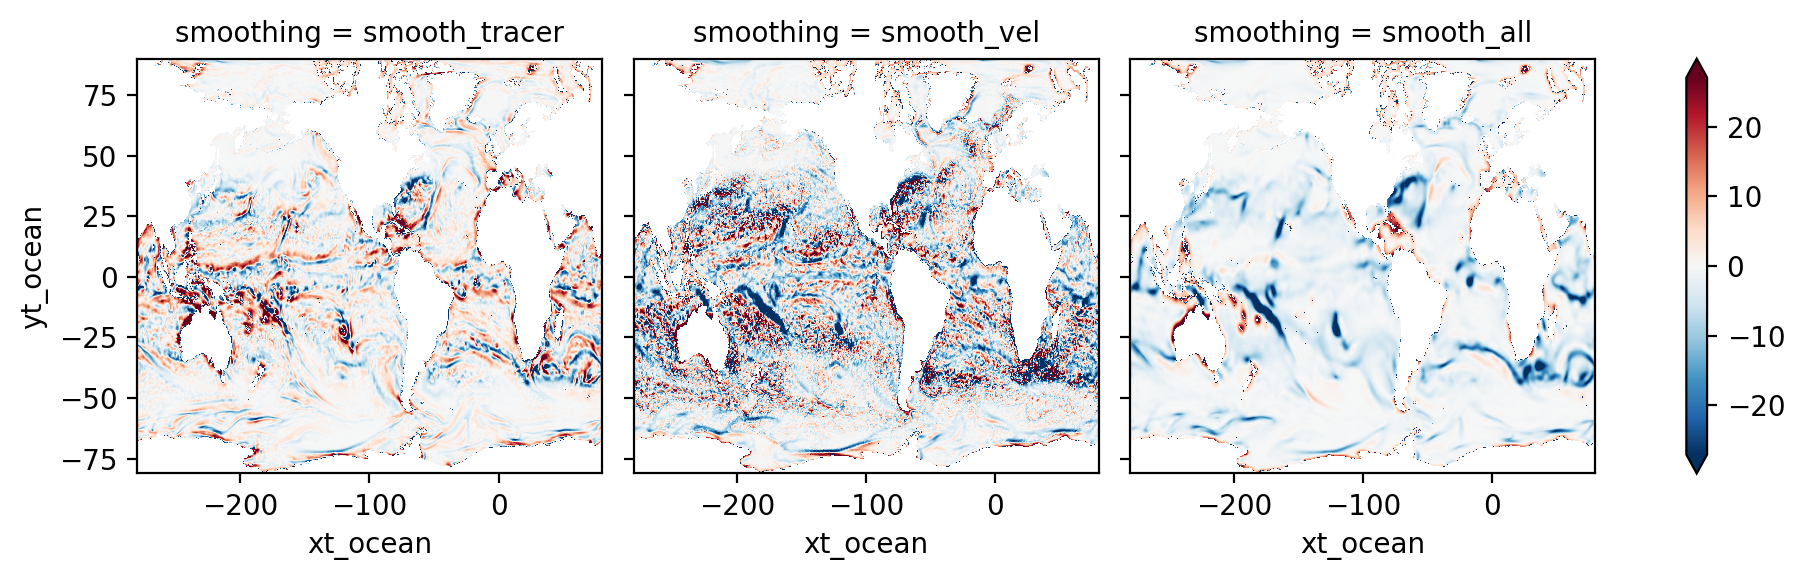

In [32]:
test_da = ds['ql'].sel(algo='ecmwf').isel(time=120)
ref_da = test_da.isel(smoothing=0)
test_da = smooth_inputs(ref_da, (~np.isnan(ref_da)).astype(int),  ['xt_ocean', 'yt_ocean'], 50) - test_da.isel(smoothing=slice(1,None))

test_da.plot(col='smoothing',robust=True, x='xt_ocean')

In [17]:
ds_plot = ds_small_scale['ql'].sel(algo='ecmwf').isel(time=[0,10, 30, 120, 200]).load()

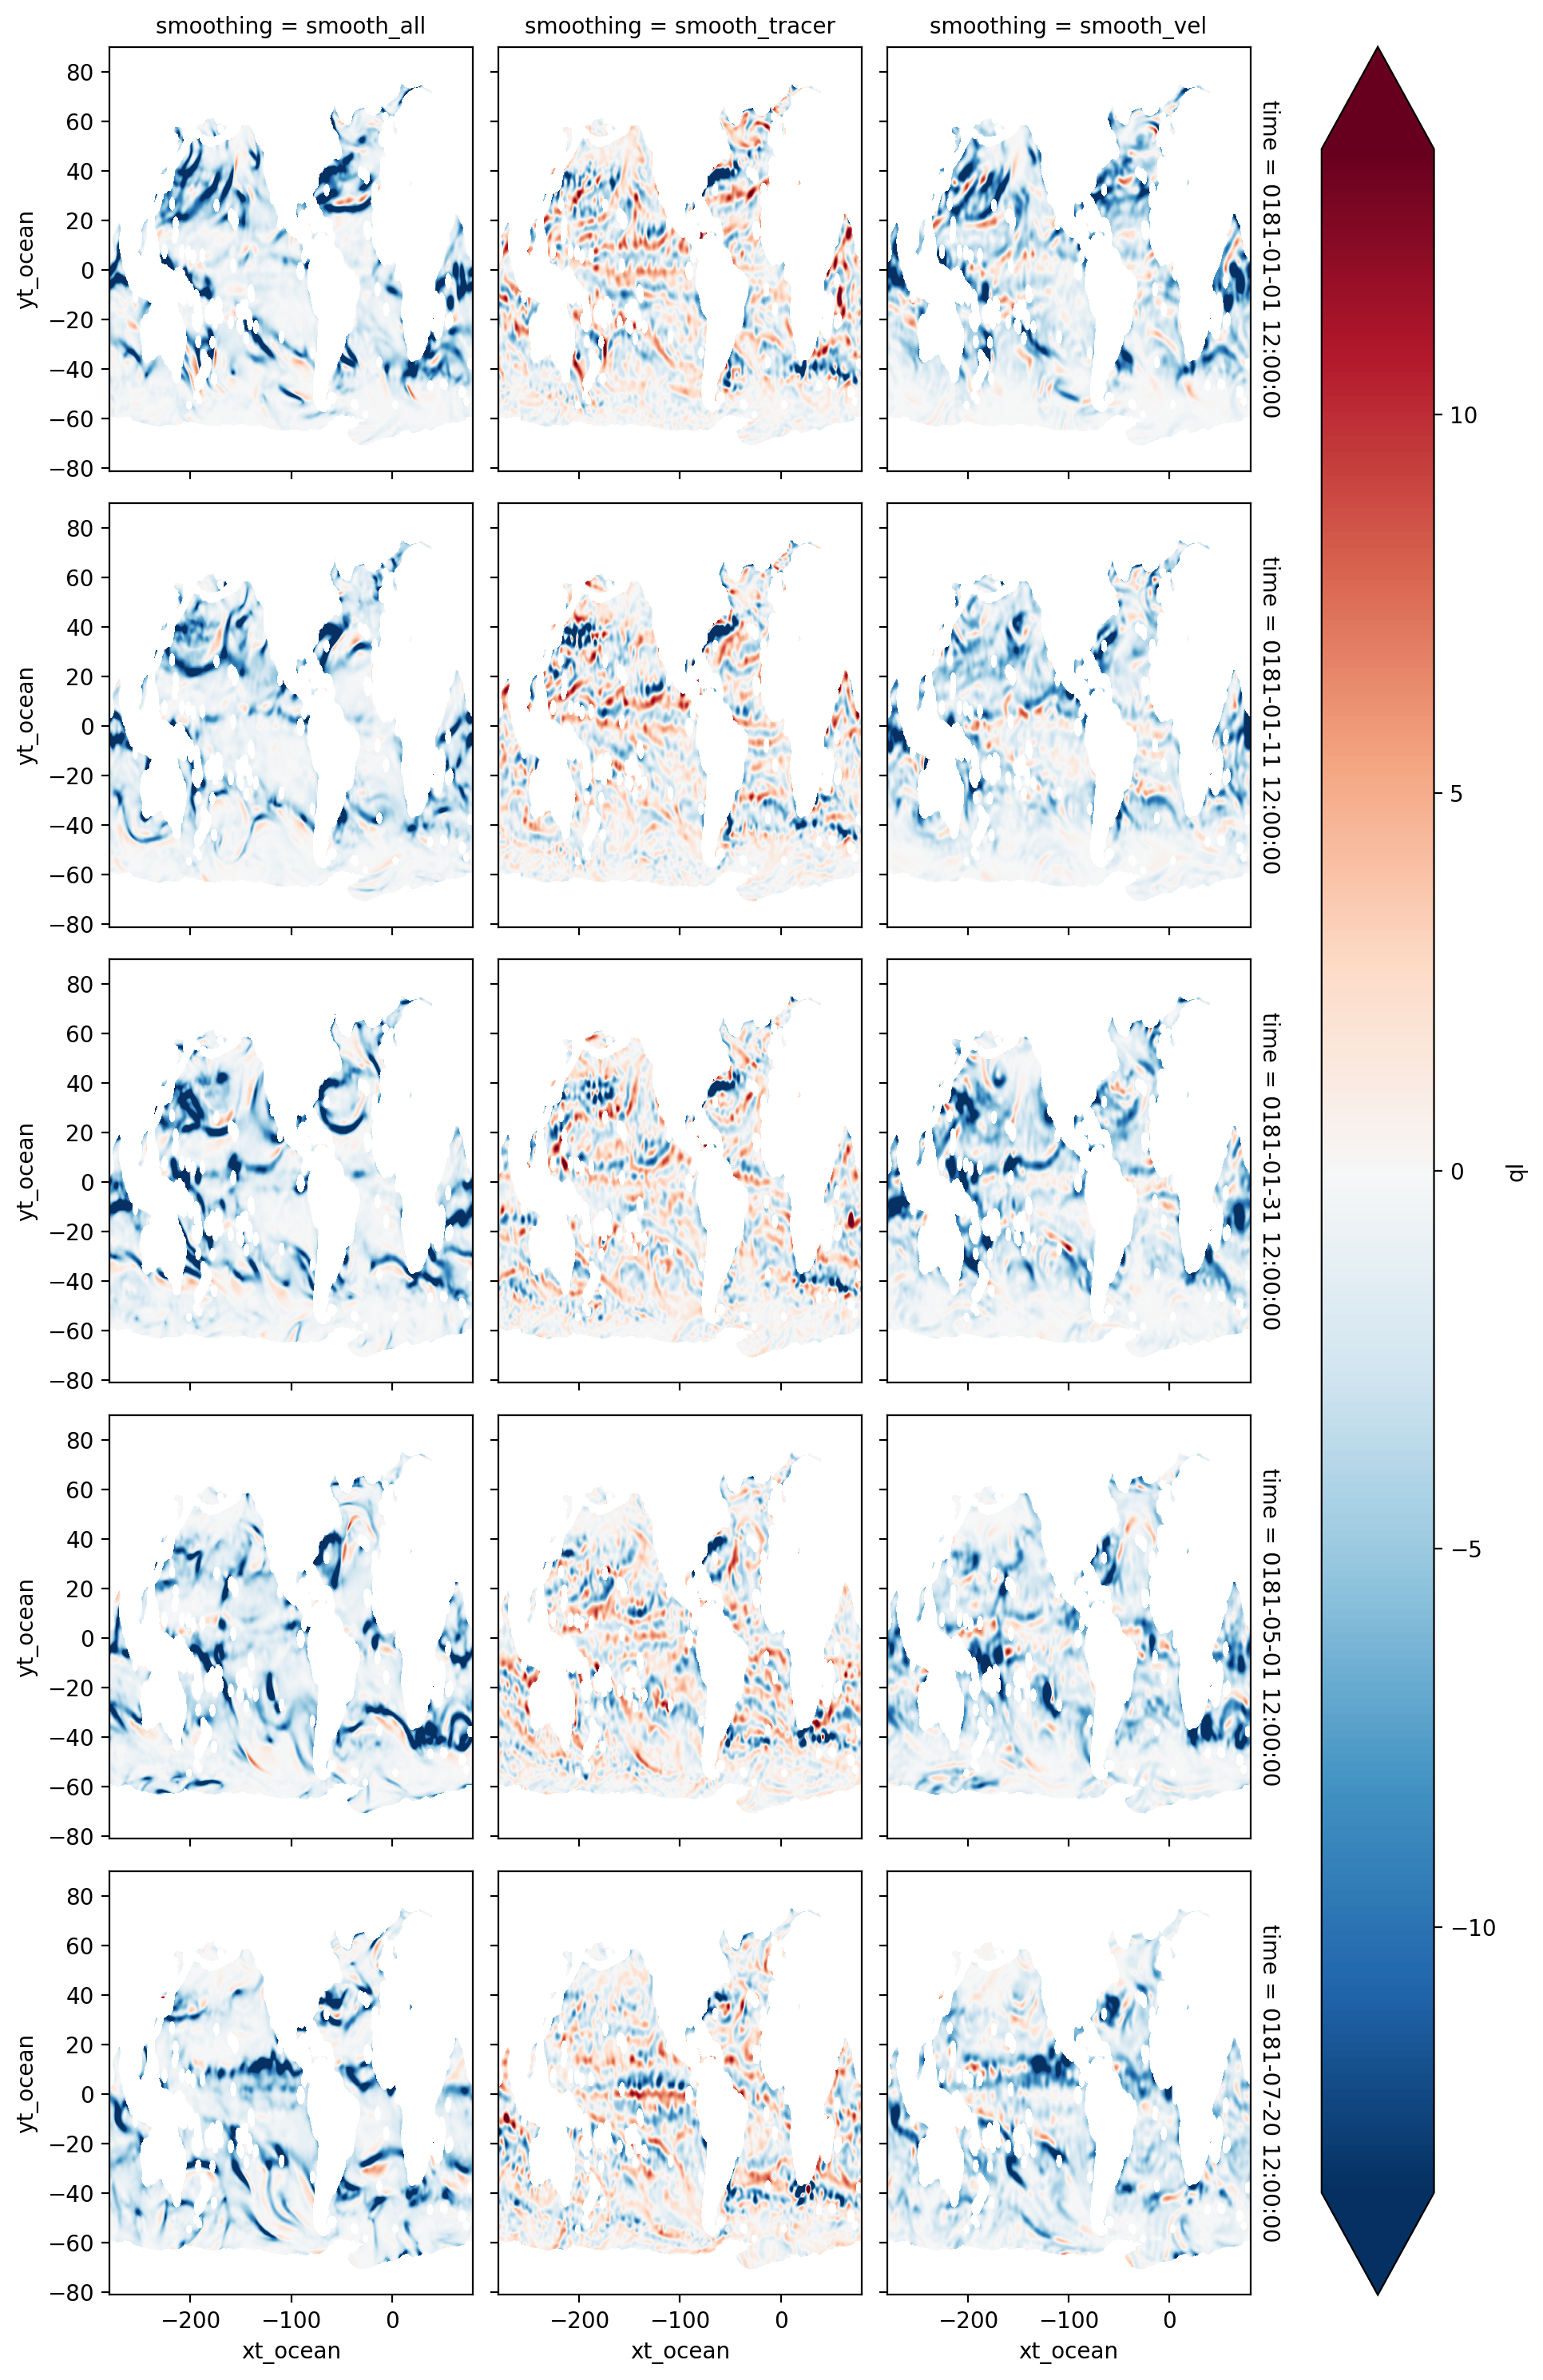

In [18]:
ds_plot.plot(col='smoothing', row='time', robust=True)

## Full daily histogram of bar(Q(t,u)) and q(bar(t), bar(u))

In [42]:
# can I persist the dataset itself? WTF is going on here?
var = 'ql'
tt = slice(0,150)
ds_persisted = ds[[var]].isel(time=tt)#.persist()

In [43]:
flux_full = smooth_inputs_dataset(ds_persisted.sel(smoothing='smooth_full', algo='ecmwf'), ['yt_ocean', 'xt_ocean'], filter_scale).where(mask_combined)
flux_large_scale = ds_persisted.sel(smoothing='smooth_all', algo='ecmwf').where(mask_combined)

In [44]:
# flux_full = smooth_inputs_dataset(ds.sel(smoothing='smooth_full', algo='ecmwf'), ['yt_ocean', 'xt_ocean'], filter_scale).where(mask_combined)
# flux_large_scale = ds.sel(smoothing='smooth_all', algo='ecmwf').where(mask_combined)

## small subset for discussion with dhruv

In [45]:
# flux_full = flux_full[[var]].isel(time=tt).load()
# flux_large_scale = flux_large_scale[[var]].isel(time=tt).load()

In [46]:
flux_full = flux_full[[var]].persist()
flux_large_scale = flux_large_scale[[var]].persist()

In [47]:
bins = np.arange(-600, 50, 2)
x = flux_full[var]
x.name = 'full_smoothed'
y = flux_large_scale[var]
y.name = 'large_scale'

hist_test = histogram(
    x,
    y,
    bins=[bins, bins],
    dim=['xt_ocean','yt_ocean']
).sum('time')

In [48]:
import matplotlib

In [ ]:
hist_test.plot(robust=True, norm=matplotlib.colors.LogNorm(), vmin=1)
line = np.linspace(-600, 50, 5)
plt.axhline(0, color='0.5')
plt.axvline(0, color='0.5')
plt.plot(line, line, 'k')

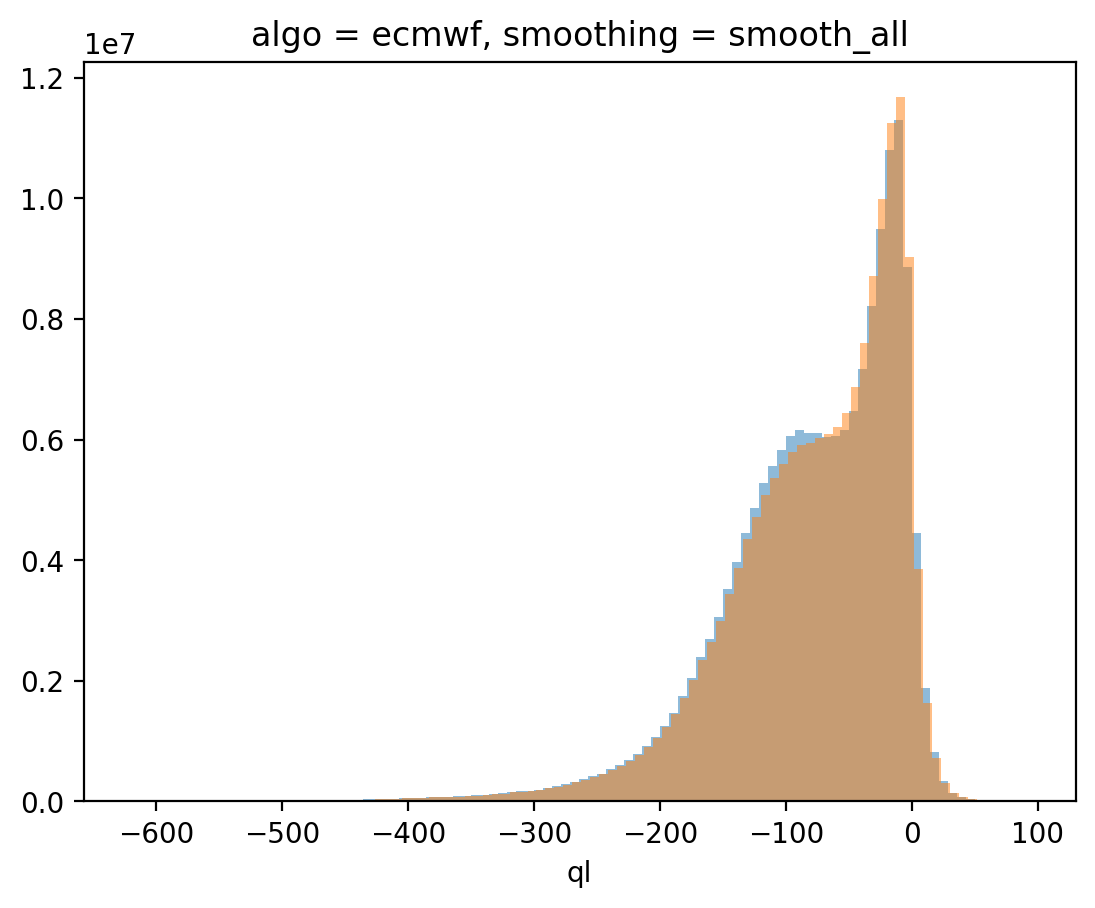

In [18]:
flux_full[var].plot.hist(bins=100, alpha=0.5, label='full_smoothed')
flux_large_scale[var].plot.hist(bins=100, alpha=0.5, label='large_scale')
plt.legend()

## this somehow failed after initially working...FIXME

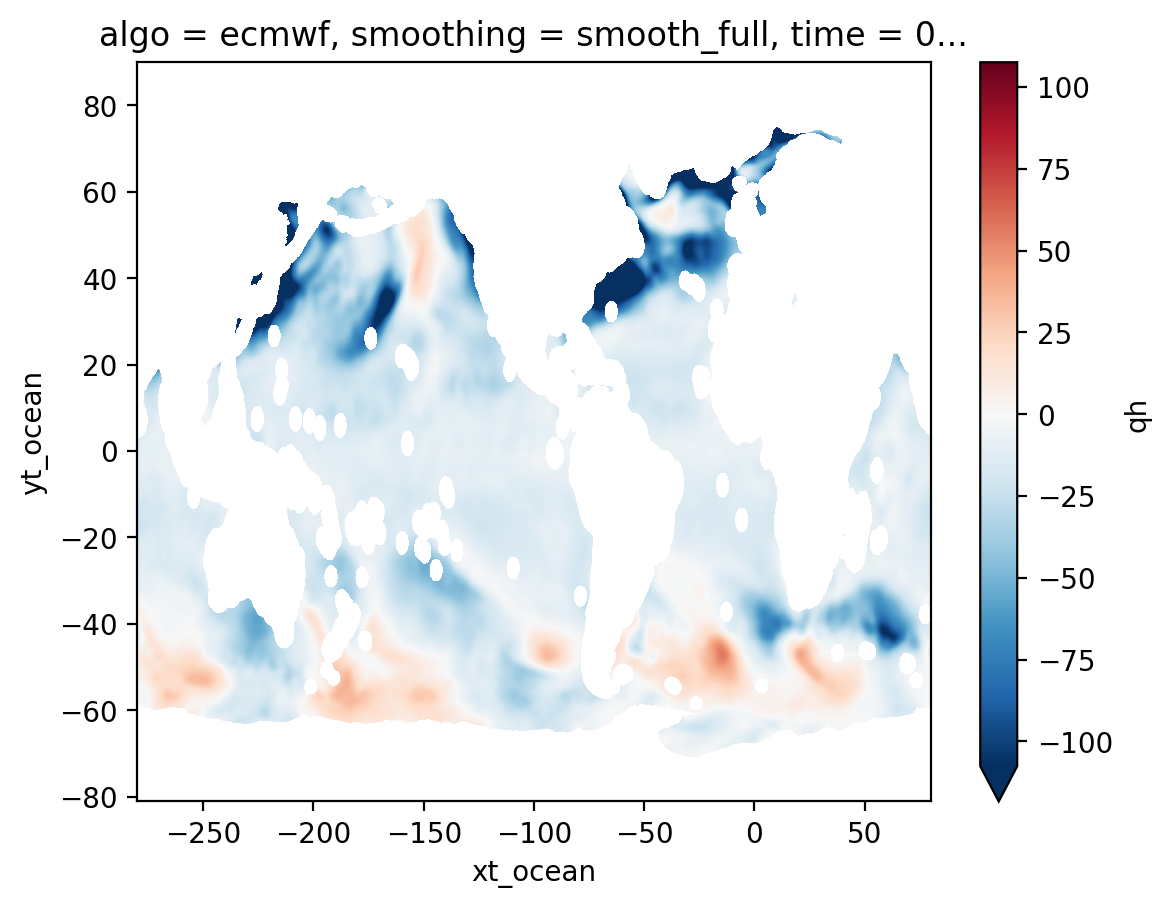

In [11]:
flux_full.isel(time=0)['qh'].plot(robust=True)

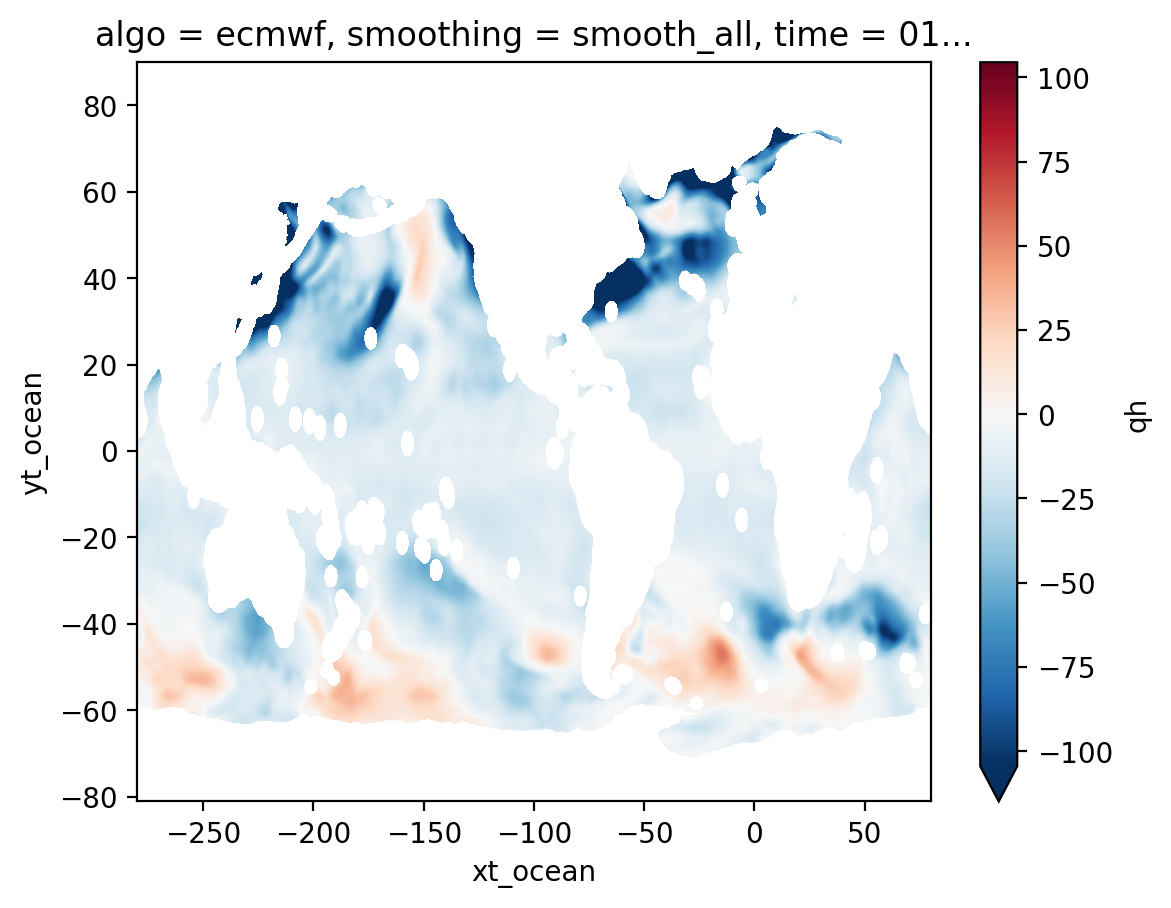

In [12]:
flux_large_scale.isel(time=0)['qh'].plot(robust=True)

In [14]:
bins = {
    'qh':np.arange(-400, 150, 1),
    'ql':np.arange(-500, 50, 1)
}

full_hist = xr.Dataset()

# for var in bins.keys():
for var in ['qh', 'ql']:
    full = flux_full[var]
    full.name = 'Full Flux'
    large = flux_large_scale[var]
    large.name = 'Large Scale Flux'
    var_hist = histogram(full,large, bins=[bins[var], bins[var]], dim=['xt_ocean', 'yt_ocean']) 
    
    # mapper = fs.get_mapper(f'ocean-transport-group/scale-aware-air-sea/results/cm26_full_flux_histogram_{var}.zarr')
    # full_hist.to_dataset(name=var).isel(time=slice(0,100)).to_zarr(mapper, consolidated=True, mode='w')

In [15]:
var_hist

<xarray.DataArray 'histogram_Full Flux_Large Scale Flux' (time: 7305,
                                                          Full Flux_bin: 549,
                                                          Large Scale Flux_bin: 549)>
dask.array<sum-aggregate, shape=(7305, 549, 549), dtype=int64, chunksize=(3, 549, 549), chunktype=numpy.ndarray>
Coordinates:
  * time                  (time) object 0181-01-01 12:00:00 ... 0200-12-31 12...
  * Full Flux_bin         (Full Flux_bin) float64 -499.5 -498.5 ... 47.5 48.5
  * Large Scale Flux_bin  (Large Scale Flux_bin) float64 -499.5 -498.5 ... 48.5

In [14]:
# mapper = fs.get_mapper(f'ocean-transport-group/scale-aware-air-sea/results/cm26_full_flux_histogram.zarr')
# full_hist.isel(time=slice(0,10)).to_zarr(mapper, consolidated=True, mode='w')

In [15]:
full_hist.isel(time=slice(0,10)).load()

CancelledError: ('getitem-2ed63fe103c2bd18c168d0753af10ff4', 3, 0, 0)

### Plotty, Plotty some histograms ...

In [16]:
# full_hist_loaded = xr.open_dataset(mapper, engine='zarr').sum('time').load()
full_hist_loaded = full_hist.isel(time=slice(0,10)).load()


KeyboardInterrupt



In [17]:
client.restart()


KeyboardInterrupt



In [31]:
import matplotlib

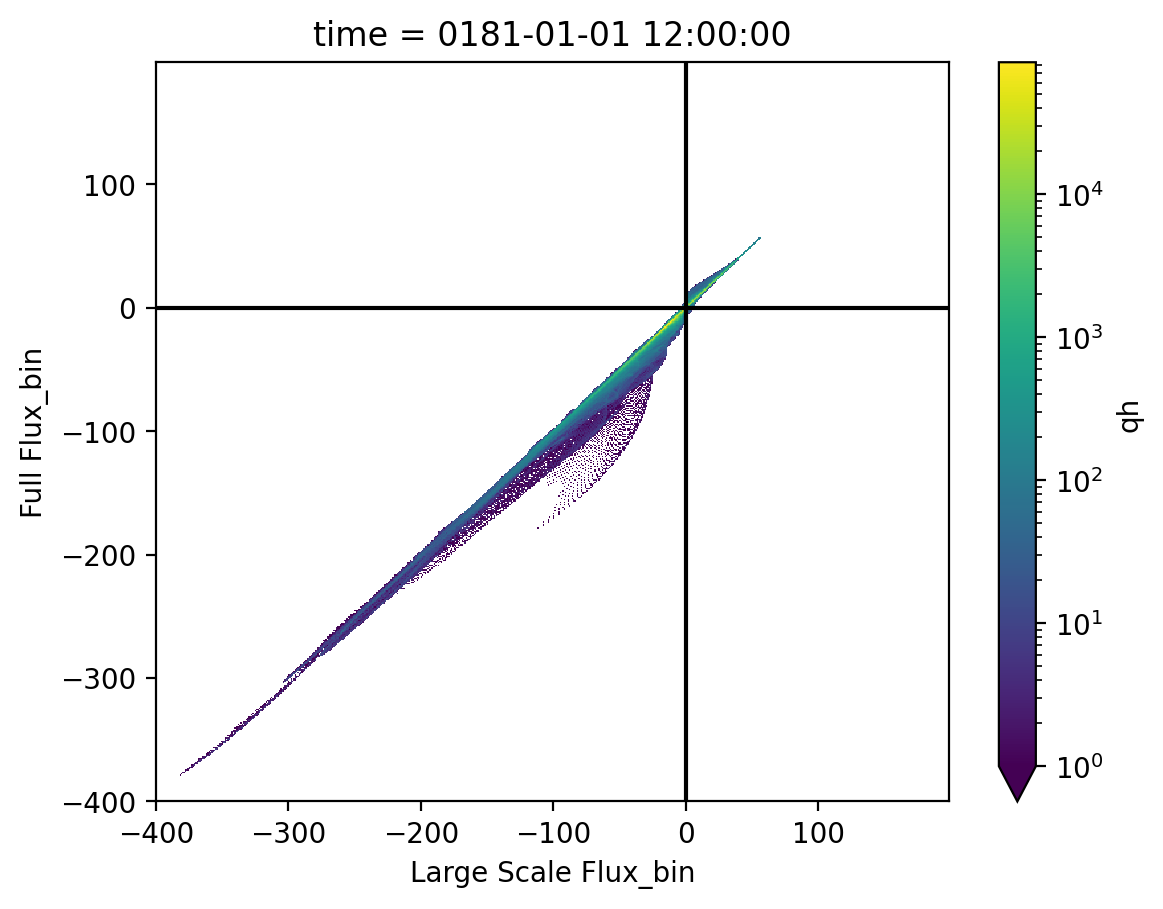

In [32]:
full_hist_loaded['qh'].plot(norm=matplotlib.colors.LogNorm(), vmin=1)
plt.axhline(0, color='k')
plt.axvline(0, color='k')

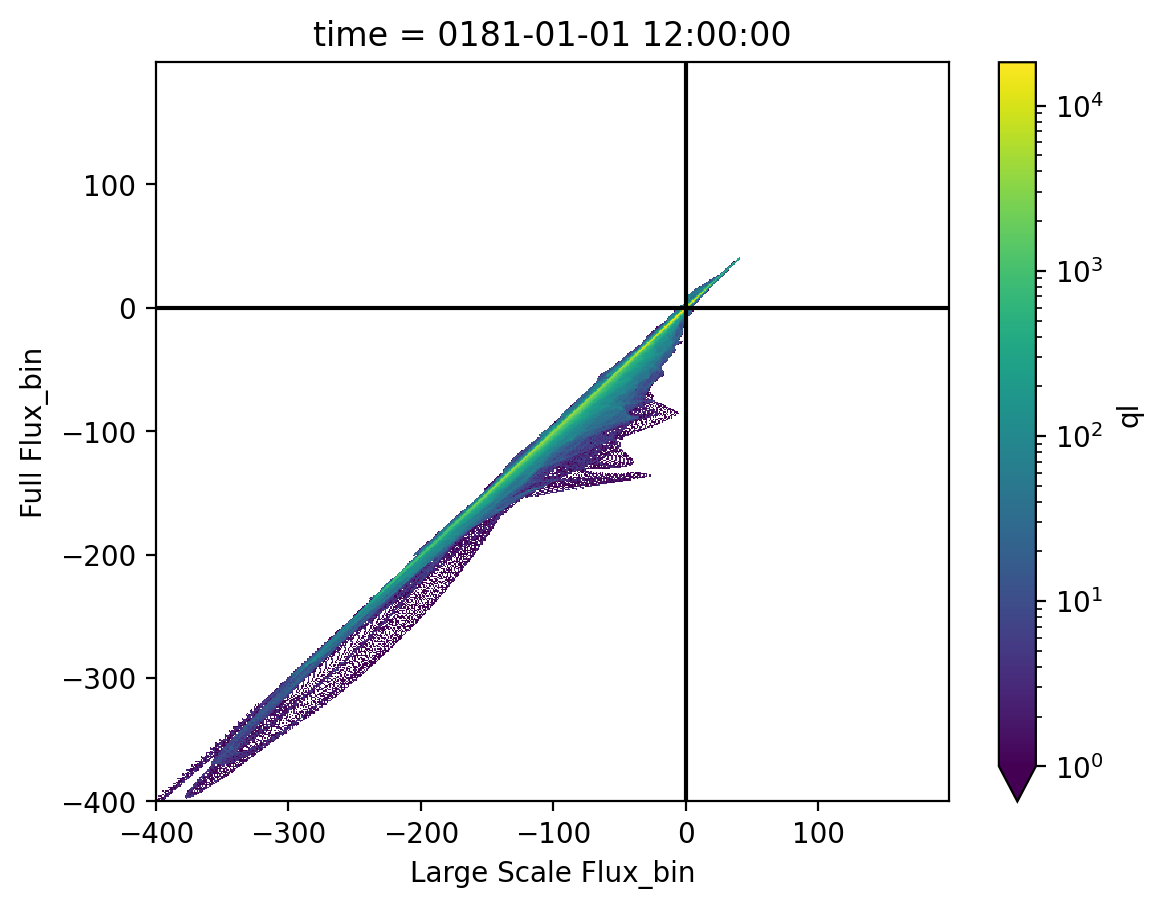

In [33]:
full_hist_loaded['ql'].plot(norm=matplotlib.colors.LogNorm(), vmin=1)
plt.axhline(0, color='k')
plt.axvline(0, color='k')

## quick check that I can save myself the one sided histogram calculation? Yuuup. Just sum over the other dimension!

## double check against aerobulk paper

In [45]:
with ProgressBar():
    std = ds_large_scale_mean.qh.std('algo').load()
    mean = ds_large_scale_mean.qh.mean('algo').load()

[####################################### ] | 98% Completed | 76.84 sms

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 77.75 s
[########################################] | 100% Completed | 73.23 ss


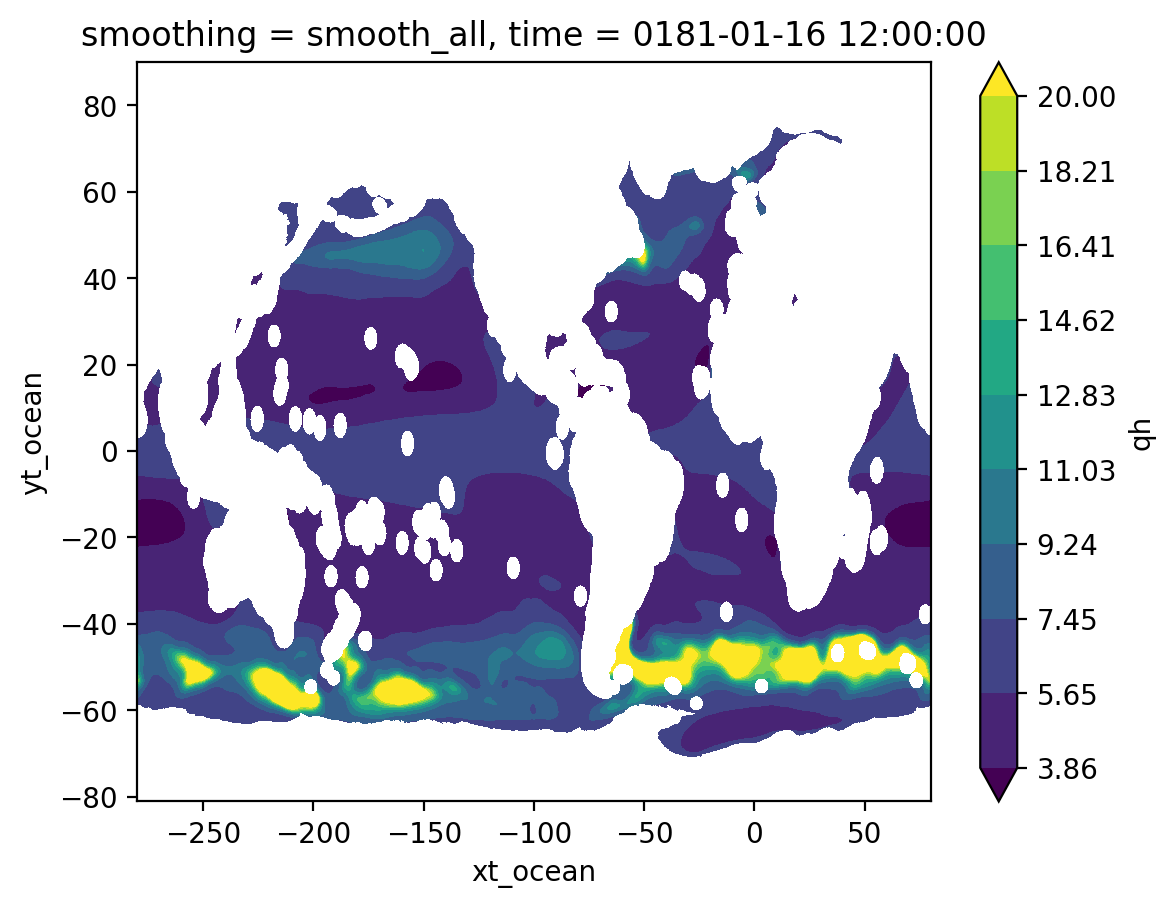

In [50]:
(std/abs(mean)*100).plot(robust=True, levels=10, vmax=20)

## Scatter plot for long term mean

In [36]:
# determine eke bins

(array([4.065354e+06, 9.040980e+05, 4.122150e+05, 2.288290e+05,
        1.275790e+05, 8.528000e+04, 5.383000e+04, 3.342100e+04,
        2.390600e+04, 1.953000e+04, 1.507400e+04, 1.070100e+04,
        7.905000e+03, 6.017000e+03, 3.898000e+03, 3.152000e+03,
        3.128000e+03, 2.530000e+03, 1.956000e+03, 1.414000e+03,
        1.205000e+03, 9.130000e+02, 7.650000e+02, 5.890000e+02,
        4.520000e+02, 3.410000e+02, 2.880000e+02, 2.320000e+02,
        2.270000e+02, 2.030000e+02, 1.090000e+02, 1.000000e+02,
        7.100000e+01, 6.200000e+01, 6.000000e+01, 5.200000e+01,
        4.300000e+01, 5.000000e+01, 3.200000e+01, 4.100000e+01,
        4.200000e+01, 3.900000e+01, 2.500000e+01, 3.400000e+01,
        3.000000e+01, 1.600000e+01, 2.600000e+01, 1.600000e+01,
        2.100000e+01]),
 array([0.        , 0.0122449 , 0.0244898 , 0.03673469, 0.04897959,
        0.06122449, 0.07346939, 0.08571429, 0.09795918, 0.11020408,
        0.12244898, 0.13469388, 0.14693878, 0.15918367, 0.17142857,
    

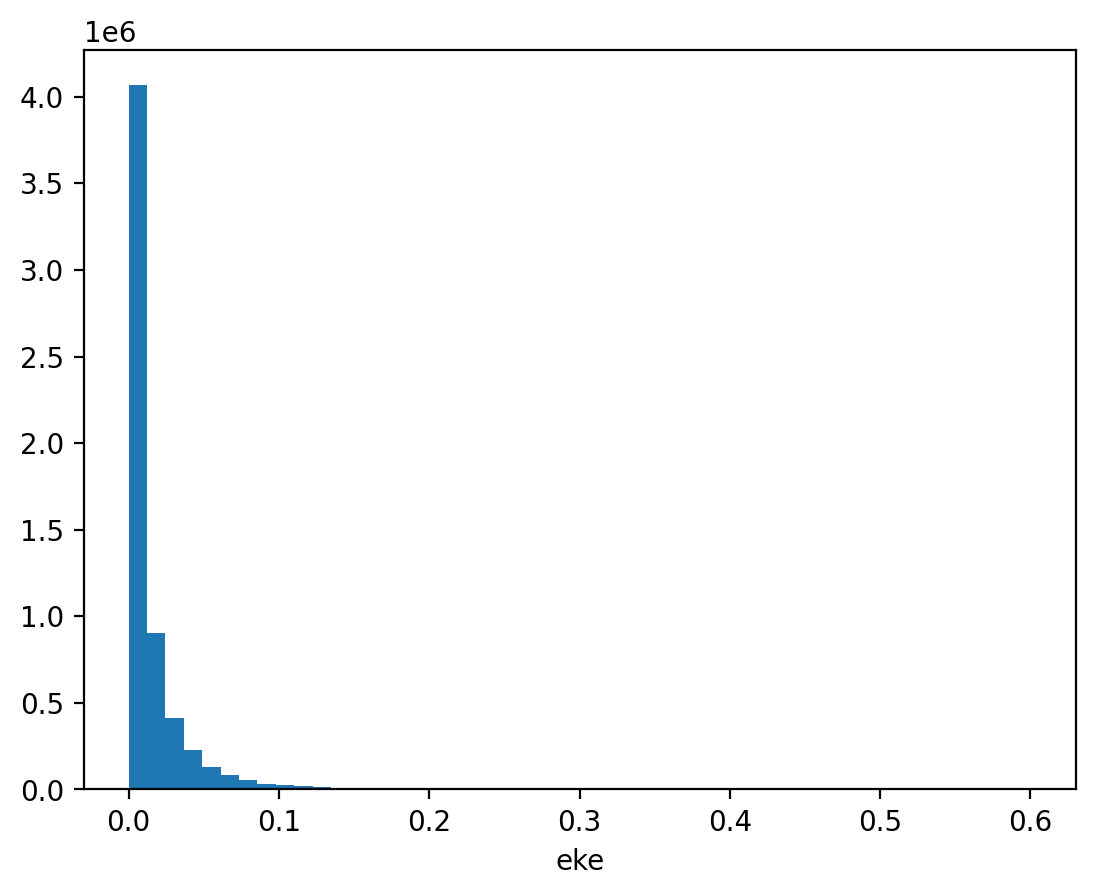

In [39]:
bins = np.linspace(0, 0.6, 50)
ds_eke.eke.plot.hist(bins=bins)

/tmp/ipykernel_889/2480652975.py:1: RuntimeWarning: divide by zero encountered in log10
  bins = np.log10(np.linspace(0, 0.6, 50))
/srv/conda/envs/notebook/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6743: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


(array([4.065354e+06, 9.040980e+05, 4.122150e+05, 2.288290e+05,
        1.275790e+05, 8.528000e+04, 5.383000e+04, 3.342100e+04,
        2.390600e+04, 1.953000e+04, 1.507400e+04, 1.070100e+04,
        7.905000e+03, 6.017000e+03, 3.898000e+03, 3.152000e+03,
        3.128000e+03, 2.530000e+03, 1.956000e+03, 1.414000e+03,
        1.205000e+03, 9.130000e+02, 7.650000e+02, 5.890000e+02,
        4.520000e+02, 3.410000e+02, 2.880000e+02, 2.320000e+02,
        2.270000e+02, 2.030000e+02, 1.090000e+02, 1.000000e+02,
        7.100000e+01, 6.200000e+01, 6.000000e+01, 5.200000e+01,
        4.300000e+01, 5.000000e+01, 3.200000e+01, 4.100000e+01,
        4.200000e+01, 3.900000e+01, 2.500000e+01, 3.400000e+01,
        3.000000e+01, 1.600000e+01, 2.600000e+01, 1.600000e+01,
        2.100000e+01]),
 array([       -inf, -1.91204483, -1.61101483, -1.43492357, -1.30998484,
        -1.21307483, -1.13389358, -1.06694679, -1.00895484, -0.95780232,
        -0.91204483, -0.87065214, -0.83286358, -0.79810148, -0

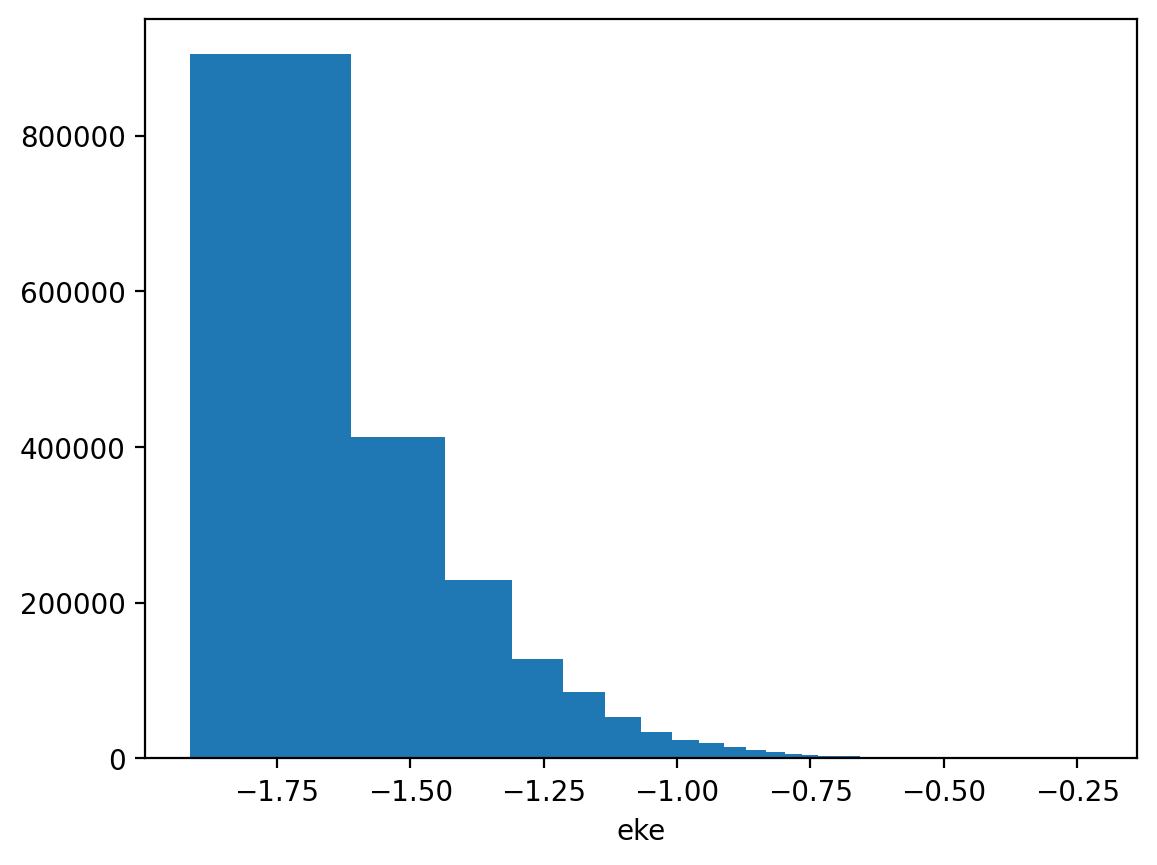

In [40]:
bins = np.log10(np.linspace(0, 0.6, 50))
np.log10(ds_eke.eke).plot.hist(bins=bins)

In [15]:
small = ds_small_scale_mean['qh'].sel(algo='ecmwf', smoothing='smooth_all')
full = ds_full_mean['qh'].sel(algo='ecmwf')

# need to rename the variables
small.name = 'qh_small'
full.name = 'qh_full'

with ProgressBar():
    full = full.load()
    small = small.load()

[########################################] | 100% Completed | 133.38 s
[########################################] | 100% Completed | 131.65 s


In [25]:
from xhistogram.xarray import histogram
hist = histogram(small, full, bins=[np.linspace(-80, 5, 300), np.linspace(-100, 20, 300)], dim=['xt_ocean', 'yt_ocean'])

In [26]:
hist

<xarray.DataArray 'histogram_qh_small_qh_full' (qh_small_bin: 299,
                                                qh_full_bin: 299)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * qh_small_bin  (qh_small_bin) float64 -79.86 -79.57 -79.29 ... 4.574 4.858
  * qh_full_bin   (qh_full_bin) float64 -99.8 -99.4 -99.0 ... 19.0 19.4 19.8

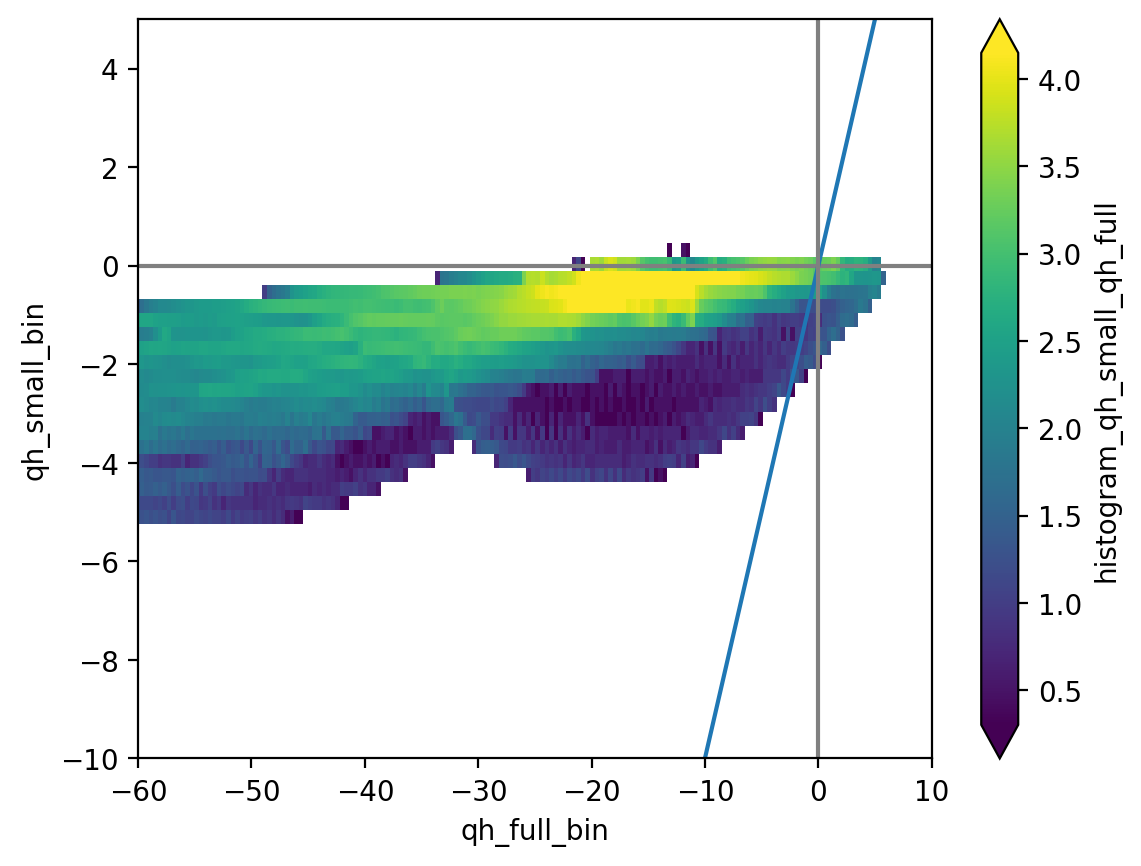

In [29]:
np.log10(hist).plot(robust=True)
# hist.where(hist>0).plot(robust=True)
plt.axhline(0,color='0.5')
plt.plot(np.arange(-300, 100), np.arange(-300, 100))
plt.xlim([-60, 10])
plt.ylim([-10, 5])
plt.axvline(0,color='0.5')

## Histogram for daily timesteps

In [31]:
# test_time = slice(0,700)
time_slice = slice(0,2000)

small = ds_small_scale['qh'].isel(time=time_slice).sel(algo='ecmwf', smoothing='smooth_all')
full = ds_full['qh'].isel(time=time_slice).sel(algo='ecmwf')

# need to rename the variables
small.name = 'qh_small'
full.name = 'qh_full'

In [33]:
hist.nbytes/1e9

0.000715208

In [75]:
hist = histogram(small, full, bins=[np.linspace(-120, 20, 100), np.linspace(-400, 100, 100)], dim=['xt_ocean', 'yt_ocean'])

In [76]:
hist = hist.sum('time')

In [ ]:
## notes
- Calculate mean EKE
- 3D hist with EKE
- Explore time averaging
- Plots:
    - Full vs Small Scatter (for high/low EKE)
    - Small vs EKE

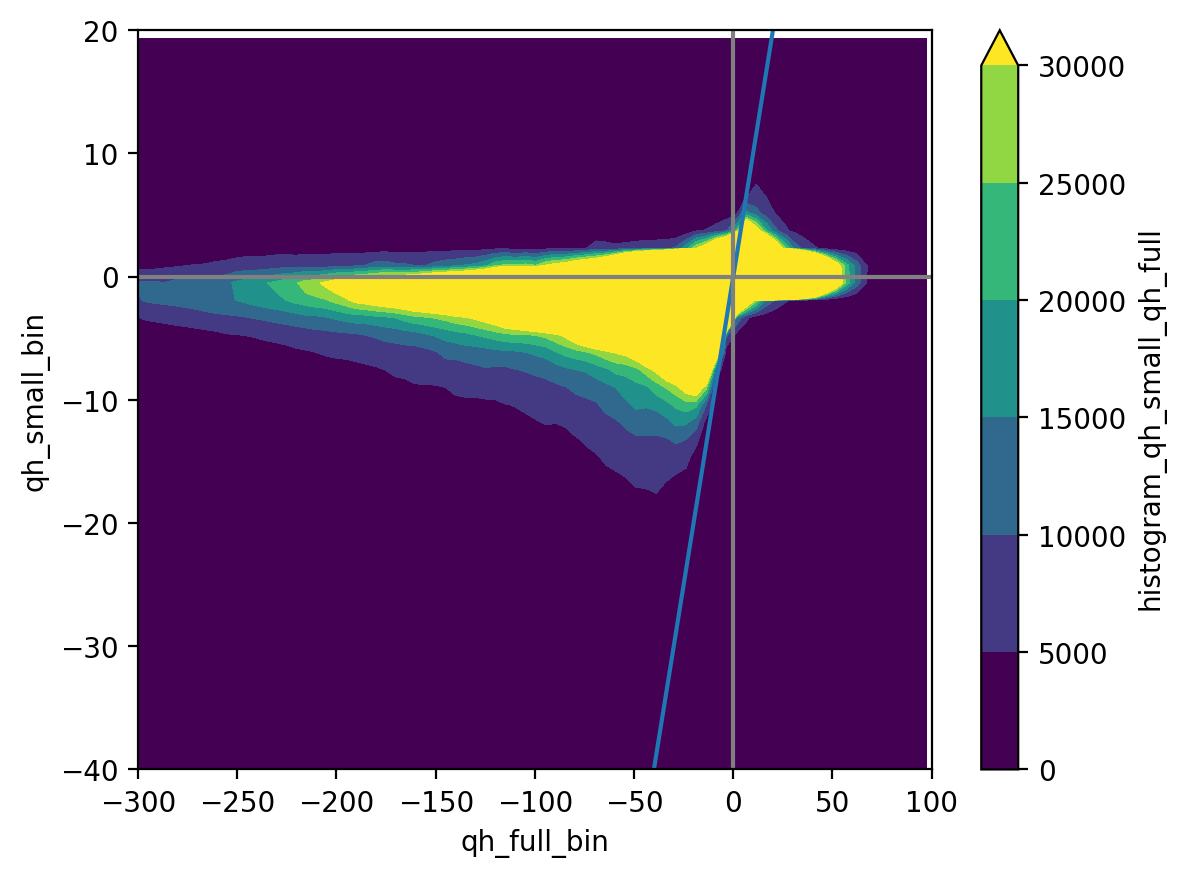

In [88]:
hist.plot.contourf(robust=True)
# hist.where(hist>0).plot(robust=True)
plt.axhline(0,color='0.5')
plt.plot(np.arange(-300, 100), np.arange(-300, 100))
plt.xlim([-300, 100])
plt.ylim([-40, 20])
plt.axvline(0,color='0.5')

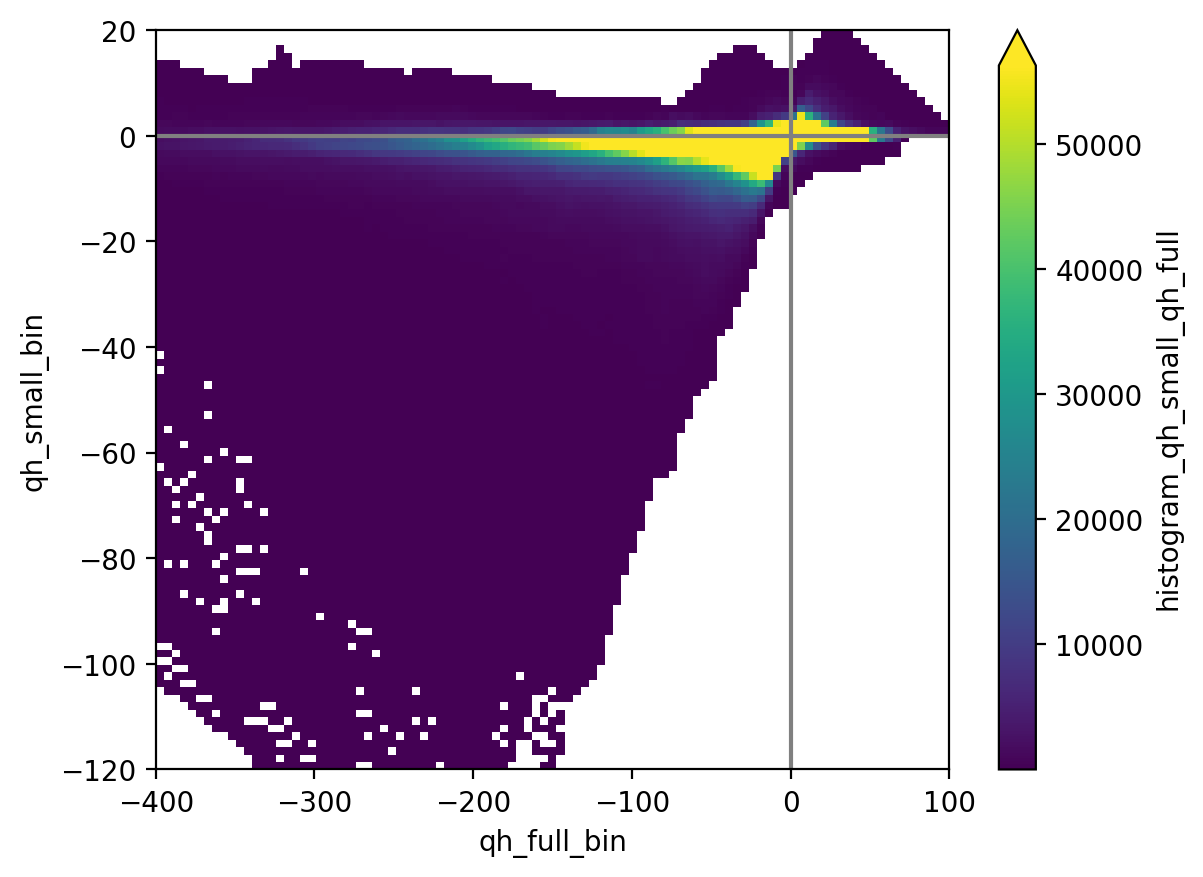

In [77]:
np.log10(hist).where(hist>0).plot(robust=True)
# hist.where(hist>0).plot(robust=True)
plt.axhline(0,color='0.5')
plt.axvline(0,color='0.5')

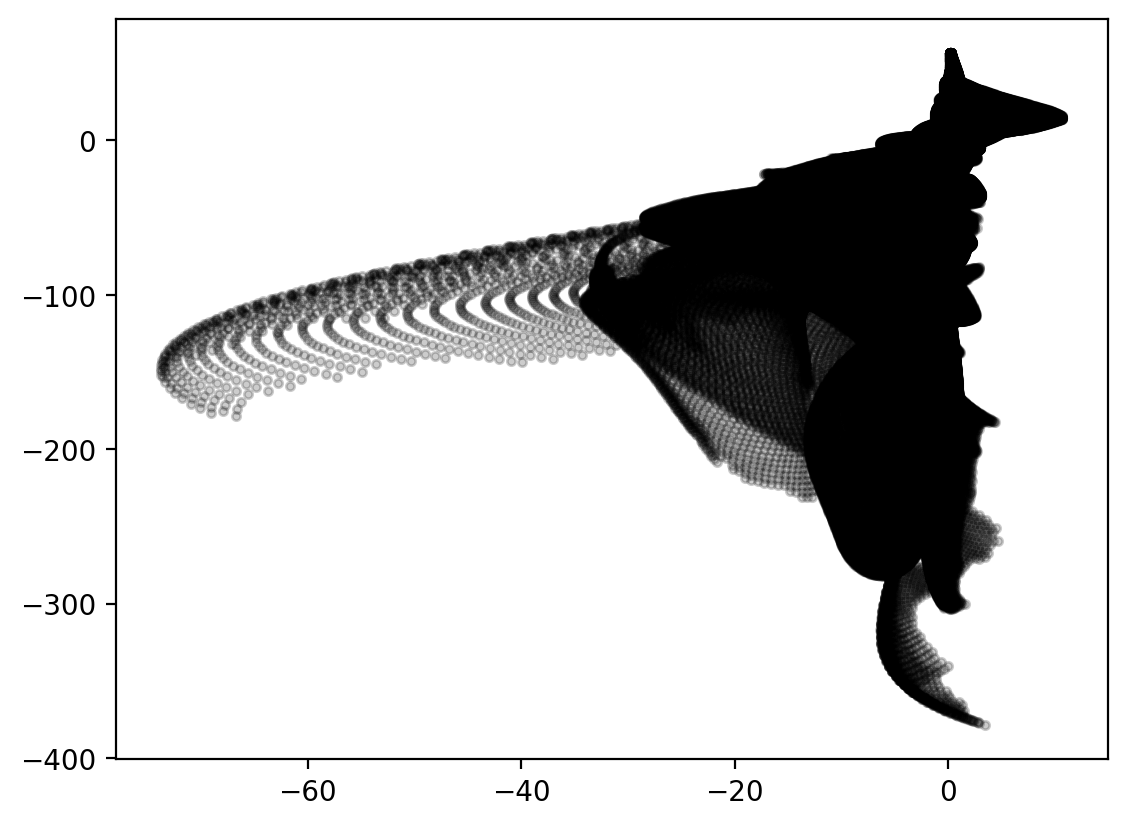

In [29]:
plt.plot(small.load().data.flat, full.load().data.flat, '.', color='k', alpha=0.2)